# Analysis of Roll20 dice rolls

This notebook examines the dice rolls reported in the Roll20 chat for a given campaign, and the distribution of dice rolls for each character. This is based on the (typically human) experience of believing that my character seemed to be rolling a lot more nat 1s and other low numbers compared with my party members. Is it confirmation bias or is Roll20 really giving me dud rolls.

To use the notebook, you need to download the full chat log from your Roll20 campaign (open it in 'single page' mode and then do a Save As in the browser to capture the entire page and its resources -- though you only need the HTML) and then update the 'chatlog_fn' path, and also put your campaign's characters' names in the 'CHARACTERS' list. These need to match what is used in the chat log. 

**NB** As my DM uses a number of home brew rules and macros, some of the parsing logic may not make sense for your campaign.



In [94]:
from bs4 import BeautifulSoup
from random import randint

import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [95]:
# chatlog_fn = 'Glaive of The Revenant King Roll20.htm'
# chatlog_fn = 'Chat Log for Glaive of The Revenant King.htm'
# chatlog_fn = 'Chat Log for Glaive of The Revenant King-20220309.htm'
chatlog_fn = 'Chat Log for Glaive of The Revenant King-20220608.html.gz'  # in the current directory

def open_file(fn):
    if fn[-1] in 'zZ':  # assume it's gzipped
        return gzip.open(fn, 'rt', encoding='utf-8')
    else:
        return open(fn, 'r', encoding='utf-8')

# with open(chatlog_fn, 'r', encoding='utf-8') as in_f:
with open_file(chatlog_fn) as in_f:
    roll20_content = in_f.read()
    
print(f'{chatlog_fn}: {len(roll20_content):,} chars')

Chat Log for Glaive of The Revenant King-20220608.html.gz: 27,545,174 chars


In [96]:
soup = BeautifulSoup(roll20_content, 'html.parser')

In [97]:
# Constants and characters

VERBOSE = False
COUNT_INITIATIVE = True

CHARACTERS = [
   "Kiril Ah'hallan",
   "Penelope Merrythane",
   "Kane Khazim",
   "Lognek Oreheat",
   "Jester Feonista",
   "Aliyah Ramirez" 
]
CHARACTER_FNS = [ ch.split(' ')[0] for ch in CHARACTERS ]
CHAR_N1_FN_MAP = { ch.split(' ')[0] : ch for ch in CHARACTERS }
CHAR_FN_N1_MAP = { ch : ch.split(' ')[0] for ch in CHARACTERS }



In [98]:
general_messages = soup.find_all('div', class_='message')

print(f'Messages: {len(general_messages):,}')

def add_roll(roll_map, name, roll):
    if name not in roll_map:
        roll_map[name] = []
    roll_map[name].append(int(roll))
    
def extract_roll_text(text, before_roll, after_roll):
    bdr_idx = text.index(before_roll)
    next_lt = text.index(after_roll, bdr_idx)
    return text[bdr_idx + len(before_roll):next_lt]



crits = { ch : 0 for ch in CHARACTERS }
nat1s = { ch : 0 for ch in CHARACTERS }
initiatives = { ch : [] for ch in CHARACTERS } # first name only
all_rolls = {}
first_rolls = {}
other_rolls = {}  # message : count
try:
    for msg in general_messages:
        if msg.find('div', class_='sheet-charname'):
            charname = list(msg.find('div', class_='sheet-charname').children)[1].get_text()

            if VERBOSE: print(charname)
            if charname not in CHARACTERS: continue
                
            rolls = msg.find_all('span', class_='inlinerollresult')
            first_roll = True
            for r in rolls:
                r_str = str(r)
                if '"basicdiceroll"&gt;' in r_str:
                    roll = extract_roll_text(r_str, '"basicdiceroll"&gt;', '&lt;')
                elif '"basicdiceroll">' in r_str:
                    if 'Rolling 1d20' in r['title']:
                        roll = extract_roll_text(r['title'], '"basicdiceroll">', '<')
                        if 'critsuccess' in roll:
                            roll = '20'
                            crits[charname] += 1
                        elif 'critfail' in roll:
                            roll = '1'
                            nat1s[charname] += 1
                        if VERBOSE: print(roll)
                elif 'basicdiceroll critsuccess' in r_str:
                    roll = '20'
                    crits[charname] += 1
                elif 'basicdiceroll critfail' in r_str:
                    roll = '1'
                    nat1s[charname] += 1                    
                else:
                    # Luckstones, Tabard of Protection bonuses, and saves in spell descriptions
                    # print('---- CAN\'T FIND NUTHIN ----')
                    title_key = 'title'
                    if not r.get(title_key):
                        title_key = 'original-title'
                    if r[title_key] not in other_rolls:
                        other_rolls[r[title_key]] = 0
                    other_rolls[r[title_key]] += 1
                    # if 'Luckstone' not in r['title'] and 'SAVE' not in r['title'] and 'Tabard' not in r['title']:
                    #     print(r['title'])
                    continue
                if VERBOSE: print(roll)
                add_roll(all_rolls, charname, roll)
                if first_roll:
                    add_roll(first_rolls, charname, roll)
                    first_roll = False
        elif 'emote' in msg['class'] and 'for initiative!' in str(msg):
            # print(msg.get_text())
            # Examples (possibly homebrew):
            # Aaron Kiril rolls 9 for initiative!
            # Lognek Oreheat Penelope Merrythane rolls 13 for initiative!
            # Lognek Oreheat Lognek rolls 19 for initiative!
            terms = msg.get_text().split()

            charnames = set(terms[:terms.index('rolls')])
            for charname in charnames:
                if charname not in CHARACTER_FNS:
                    continue

                full_charname = CHAR_N1_FN_MAP[charname]

                raw_roll_text = str(list(msg.find_all('span', class_='inlinerollresult'))[0])
                if 'critsuccess' in raw_roll_text:
                    roll = '20'
                elif 'critfail' in raw_roll_text:
                    roll = '1'
                else:
                    roll = extract_roll_text(raw_roll_text, '"basicdiceroll"&gt;', '&lt;')
                # print(full_charname, roll)
                if COUNT_INITIATIVE:
                    add_roll(all_rolls, full_charname, roll)
                    add_roll(first_rolls, full_charname, roll)
                add_roll(initiatives, full_charname, roll)
except ValueError as e:
    print('------- BARF! --------')
    print(e)
    print(msg)
    
print('\nUnparseable rolls')
# look at these for guidance for what parsing conditions to add for your campaign.
# You may need to look back into the HTML to figure out what these map to and whether
# you want to capture them.
for msg, c in other_rolls.items():
    print(f'{c:>7,} : {msg}')
        
print(f'\nTotal rolls: {sum(len(rs) for rs in all_rolls.values()):,}')        

Messages: 7,920

Unparseable rolls
      7 : Rolling 5*4 = 5*4
  1,181 : Rolling 1[Luckstone] = 1
      2 : Rolling 14[SAVE] = 14
     61 : Rolling 15[SAVE] = 15
     49 : Rolling 17[SAVE] = 17
     55 : Rolling 1[Tabard of Protection] = 1
      6 : Rolling 5*5 = 5*5
      3 : Rolling 1 + 3[STR] + 1[MOD] = 1+3+1
      1 : Rolling 1 = 1
      6 : Rolling 2[CON] = 2
      1 : Rolling 1 + -1[STR] + 1[MOD] = 1+-1+1
     13 : Rolling 5*6 = 5*6
      2 : Rolling 0 + 5[STR] = 0+5
     31 : Rolling 3[CON] = 3
      2 : Rolling 4[CON] = 4
      2 : Rolling 1[CON] = 1
     25 : Rolling 16[SAVE] = 16
      7 : Rolling 5[CON] = 5
      4 : Rolling 5*7 = 5*7
      9 : Rolling 5*8 = 5*8
      5 : Rolling 18[SAVE] = 18

Total rolls: 8,370


In [99]:
# Basic tables of rolls, crits and nat 1s. I'm sure this can be done more prettily.
print(f'All rolls ({sum(len(rs) for rs in all_rolls)})')
print('Name     \tRolls\tCrits\tCrits%\tNat1s\tNat1s%\tMean')
for n, rs in all_rolls.items():
    print(f'{n.split()[0]:<10}\t{len(rs):4d}\t{crits[n]:3d}\t{crits[n]/len(rs):5.1%}\t{nat1s[n]:3d}\t{nat1s[n]/len(rs):5.1%}\t{sum(rs) / len(rs):4.1f}')
print(f'\nFirst rolls ({sum(len(rs) for rs in first_rolls)})')
# Quite often Roll20 will provide two dice rolls, letting you decide whether the first roll is required
# or which roll depending on advantage or disadvantage
print('Name     \tRolls\tCrits\tCrits%\tNat1s\tNat1s%\tMean')
for n, rs in first_rolls.items():
    print(f'{n.split()[0]:<10}\t{len(rs):4d}\t{crits[n]:3d}\t{crits[n]/len(rs):5.1%}\t{nat1s[n]:3d}\t{nat1s[n]/len(rs):5.1%}\t{sum(rs) / len(rs):4.1f}')

    
the_rolls = all_rolls #initiatives #first_rolls

All rolls (88)
Name     	Rolls	Crits	Crits%	Nat1s	Nat1s%	Mean
Kiril     	1498	 64	 4.3%	 41	 2.7%	 9.4
Penelope  	1478	 65	 4.4%	 67	 4.5%	 9.6
Jester    	1144	 71	 6.2%	 61	 5.3%	 9.4
Lognek    	1637	106	 6.5%	 58	 3.5%	 9.2
Kane      	1601	 68	 4.2%	 70	 4.4%	 9.9
Aliyah    	1012	 52	 5.1%	 41	 4.1%	 9.1

First rolls (88)
Name     	Rolls	Crits	Crits%	Nat1s	Nat1s%	Mean
Kiril     	 757	 64	 8.5%	 41	 5.4%	10.2
Penelope  	 735	 65	 8.8%	 67	 9.1%	10.4
Jester    	 620	 71	11.5%	 61	 9.8%	 9.7
Lognek    	 747	106	14.2%	 58	 7.8%	10.6
Kane      	 869	 68	 7.8%	 70	 8.1%	10.1
Aliyah    	 588	 52	 8.8%	 41	 7.0%	 9.4


Text(0.5, 1.0, 'Frequency of dice rolls by characters')

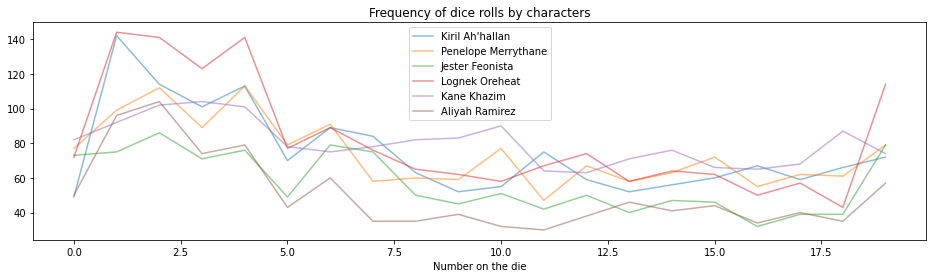

In [100]:
# How often did each character roll each die value?
def build_rolls_df(rolls):
    cols = list(rolls.keys())
    def count_rolls(rs):
        return [ rs.count(i) for i in range(1, 21) ]
    return pd.DataFrame(
        { ch : count_rolls(rolls[ch]) for ch in cols },
        columns=cols
    )

rolls_df = build_rolls_df(the_rolls)

# ax = rolls_df.plot.hist(bins=20, figsize=(12, 4), alpha=0.5)
ax = rolls_df.plot.line(figsize=(16, 4), alpha=0.5)

ax.set_xlabel('Number on the die')
ax.set_title('Frequency of dice rolls by characters')

In [ ]:
# what proportion of each characters' die rolls had each die value?
def build_rolls_norm_df(rolls):
    cols = list(rolls.keys())
    def count_rolls_norm(rs):
        return [ 100 * rs.count(i) / len(rs) for i in range(1, 21) ]
    return pd.DataFrame(
        { ch : count_rolls_norm(rolls[ch]) for ch in cols },
        columns=cols,
        index=[i for i in range(1, 21)]
    )

norm_rolls_df = build_rolls_norm_df(the_rolls)

# ax = rolls_df.plot.hist(bins=20, figsize=(12, 4), alpha=0.5)
ax = norm_rolls_df.plot.line(figsize=(16, 4), alpha=0.5)

ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in range(1, 21)]))
ax.set_xlabel('Number on the die')
ax.set_ylabel('Proportion of rolls')
ax.set_title('Distribution of dice rolls by characters')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

In [ ]:
# Break it down into quarters: 1-5, 6-10, 11-15, 16-20
def build_rolls_norm_q_df(rolls):
    cols = list(rolls.keys())
    def count_rolls_norm_q(rs):
        binned = [ 100 * rs.count(i) / len(rs) for i in range(1, 21) ]
        in_quarters = [
            sum(binned[:5]), sum(binned[5:10]), sum(binned[10:15]), sum(binned[15:])
        ]
        return in_quarters
    return pd.DataFrame(
        { ch : count_rolls_norm_q(rolls[ch]) for ch in cols },
        columns=cols,
        index=['1-5', '6-10', '11-15', '16-20']
    )

norm_rolls_q_df = build_rolls_norm_q_df(the_rolls)

ax = norm_rolls_q_df.plot.bar(figsize=(12, 4), alpha=0.5, rot=0)

ax.legend(loc='lower left')
ax.set_xlabel('Number on the die')
ax.set_ylabel('Proportion of rolls')
ax.set_title('Distribution of dice rolls by characters (by quarter)')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())



In [ ]:
# Who rolls most frequently?
def build_roll_count_df(rolls):
    cols = list(rolls.keys())
    return pd.DataFrame(
        { 'Rolls': [ len(rolls[ch]) for ch in cols ] },
        index=cols
    )

roll_counts_df = build_roll_count_df(the_rolls)

ax = roll_counts_df.plot(kind='bar', alpha=0.5, rot=0.0, figsize=(12, 4), legend=False)
ax.set_ylabel('Number of rolls')
ax.set_title('Dice rolls by characters')


In [ ]:
# Look at initiative rolls specifically.
# Ideally these should be identical, right? Maybe I'm missing initiative sometimes.
# Sometimes we make mistakes and have to roll it again too, so those botched rolls are
# still considered here.
# FYI, my DM gets us to roll initiative every round of combat, rather than just at the start.
init_roll_counts_df = build_roll_count_df(initiatives)

ax = init_roll_counts_df.plot(kind='bar', alpha=0.5, rot=0.0, figsize=(12, 4), legend=False)
ax.set_ylabel('Number of rolls')
ax.set_title('Initiative rolls by characters')

In [ ]:
# normalised initiative rolls by quarter
norm_init_rolls_q_df = build_rolls_norm_q_df(initiatives)

ax = norm_init_rolls_q_df.plot.bar(figsize=(12, 4), alpha=0.5, rot=0)

ax.legend(loc='lower center')
ax.set_xlabel('Number on the die')
ax.set_ylabel('Proportion of rolls')
ax.set_title('Distribution of initiative rolls by characters (by quarter)')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())

In [ ]:
# !conda list
# # packages in environment at C:\Users\derek\Documents\tools\Anaconda3\envs\lcn:
# #
# # Name                    Version                   Build  Channel
# argon2-cffi               20.1.0           py38he774522_1  
# async_generator           1.10                       py_0  
# atomicwrites              1.4.0                    pypi_0    pypi
# attrs                     20.2.0                     py_0  
# backcall                  0.2.0                      py_0  
# beautifulsoup4            4.9.3              pyhb0f4dca_0  
# bibtexparser              1.1.0                      py_0    conda-forge
# blas                      1.0                         mkl  
# bleach                    3.2.1                      py_0  
# botometer                 1.6                      pypi_0    pypi
# ca-certificates           2021.10.26           haa95532_2  
# certifi                   2021.10.8        py38haa95532_0  
# cffi                      1.14.3           py38h7a1dbc1_0  
# chardet                   3.0.4                    pypi_0    pypi
# click                     7.1.2              pyhd3eb1b0_0  
# click-config-file         0.6.0                    pypi_0    pypi
# click-plugins             1.1.1                    pypi_0    pypi
# colorama                  0.4.3                      py_0  
# configobj                 5.0.6                    pypi_0    pypi
# cycler                    0.10.0                   py38_0  
# decorator                 4.4.2                      py_0  
# defusedxml                0.6.0                      py_0  
# entrypoints               0.3                      py38_0  
# freetype                  2.10.2               hd328e21_0  
# future                    0.18.2                   py38_1  
# humanize                  3.13.1                   pypi_0    pypi
# icc_rt                    2019.0.0             h0cc432a_1  
# icu                       58.2                 ha925a31_3  
# idna                      2.10                     pypi_0    pypi
# importlib-metadata        1.7.0                    py38_0  
# importlib_metadata        1.7.0                         0  
# iniconfig                 1.1.1                    pypi_0    pypi
# intel-openmp              2020.2                      254  
# ipykernel                 5.3.4            py38h5ca1d4c_0  
# ipython                   7.18.1           py38h5ca1d4c_0  
# ipython_genutils          0.2.0                    py38_0  
# ipywidgets                7.5.1                      py_0  
# jedi                      0.17.2                   py38_0  
# jinja2                    2.11.2                     py_0  
# joblib                    0.17.0                     py_0    anaconda
# jpeg                      9b                   hb83a4c4_2  
# jsonschema                3.2.0                    py38_0  
# jupyter                   1.0.0                    py38_7  
# jupyter_client            6.1.6                      py_0  
# jupyter_console           6.2.0                      py_0  
# jupyter_core              4.6.3                    py38_0  
# jupyterlab_pygments       0.1.1                      py_0  
# kiwisolver                1.2.0            py38h74a9793_0  
# libiconv                  1.15                 h1df5818_7  
# libpng                    1.6.37               h2a8f88b_0  
# libsodium                 1.0.18               h62dcd97_0  
# libtiff                   4.1.0                h56a325e_1  
# libxml2                   2.9.10               hb89e7f3_3  
# libxslt                   1.1.34               he774522_0  
# lxml                      4.6.1            py38h1350720_0  
# lz4-c                     1.9.2                h62dcd97_1  
# m2w64-gcc-libgfortran     5.3.0                         6  
# m2w64-gcc-libs            5.3.0                         7  
# m2w64-gcc-libs-core       5.3.0                         7  
# m2w64-gmp                 6.1.0                         2  
# m2w64-libwinpthread-git   5.0.0.4634.697f757               2  
# markupsafe                1.1.1            py38he774522_0  
# matplotlib                3.3.1                         0  
# matplotlib-base           3.3.1            py38hba9282a_0  
# mistune                   0.8.4           py38he774522_1000  
# mkl                       2020.2                      256  
# mkl-service               2.3.0            py38hb782905_0  
# mkl_fft                   1.2.0            py38h45dec08_0  
# mkl_random                1.1.1            py38h47e9c7a_0  
# msys2-conda-epoch         20160418                      1  
# nbclient                  0.5.0                      py_0  
# nbconvert                 6.0.6                    py38_0  
# nbformat                  5.0.7                      py_0  
# nest-asyncio              1.4.0                      py_1  
# networkx                  2.5                        py_0  
# nltk                      3.5                        py_0  
# notebook                  6.1.1                    py38_0  
# numpy                     1.19.1           py38h5510c5b_0  
# numpy-base                1.19.1           py38ha3acd2a_0  
# oauthlib                  3.1.0                    pypi_0    pypi
# olefile                   0.46                       py_0  
# openssl                   1.1.1l               h2bbff1b_0  
# packaging                 20.4                       py_0  
# pandas                    1.1.1            py38ha925a31_0  
# pandoc                    2.10.1                        0  
# pandocfilters             1.4.2                    py38_1  
# parso                     0.7.0                      py_0  
# pickleshare               0.7.5                 py38_1000  
# pillow                    7.2.0            py38hcc1f983_0  
# pip                       20.2.2                   py38_0  
# pluggy                    0.13.1                   pypi_0    pypi
# prometheus_client         0.8.0                      py_0  
# prompt-toolkit            3.0.7                      py_0  
# prompt_toolkit            3.0.7                         0  
# py                        1.10.0                   pypi_0    pypi
# pycparser                 2.20                       py_2  
# pygments                  2.7.1                      py_0  
# pyparsing                 2.4.7                      py_0  
# pyqt                      5.9.2            py38ha925a31_4  
# pyrsistent                0.17.3           py38he774522_0  
# pytest                    6.2.1                    pypi_0    pypi
# python                    3.8.5                h5fd99cc_1  
# python-dateutil           2.8.1                      py_0  
# python-louvain            0.14                       py_0  
# python_abi                3.8                      1_cp38    conda-forge
# pytz                      2020.1                     py_0  
# pywin32                   227              py38he774522_1  
# pywinpty                  0.5.7                    py38_0  
# pyzmq                     19.0.2           py38ha925a31_1  
# qt                        5.9.7            vc14h73c81de_0  
# qtconsole                 4.7.7                      py_0  
# qtpy                      1.9.0                      py_0  
# regex                     2020.11.13       py38h2bbff1b_0  
# requests                  2.24.0                   pypi_0    pypi
# requests-oauthlib         1.3.0                    pypi_0    pypi
# scikit-learn              0.23.2           py38h47e9c7a_0  
# scipy                     1.5.0            py38h9439919_0  
# seaborn                   0.11.0                     py_0  
# send2trash                1.5.0                    py38_0  
# setuptools                49.6.0                   py38_0  
# sip                       4.19.13          py38ha925a31_0  
# six                       1.15.0                     py_0  
# soupsieve                 2.0.1                      py_0  
# sqlite                    3.33.0               h2a8f88b_0  
# terminado                 0.8.3                    py38_0  
# testpath                  0.4.4                      py_0  
# threadpoolctl             2.1.0              pyh5ca1d4c_0  
# tk                        8.6.10               he774522_0  
# toml                      0.10.2                   pypi_0    pypi
# tornado                   6.0.4            py38he774522_1  
# tqdm                      4.62.3                   pypi_0    pypi
# traitlets                 4.3.3                    py38_0  
# twarc                     2.8.2                    pypi_0    pypi
# tweepy                    3.9.0                    pypi_0    pypi
# urllib3                   1.25.11                  pypi_0    pypi
# vc                        14.1                 h0510ff6_4  
# vs2015_runtime            14.16.27012          hf0eaf9b_3  
# wcwidth                   0.2.5                      py_0  
# webencodings              0.5.1                    py38_1  
# wheel                     0.35.1                     py_0  
# widgetsnbextension        3.5.1                    py38_0  
# wincertstore              0.2                      py38_0  
# winpty                    0.4.3                         4  
# wordcloud                 1.8.0            py38h1e8a9f7_0    conda-forge
# xz                        5.2.5                h62dcd97_0  
# zeromq                    4.3.2                ha925a31_3  
# zipp                      3.1.0                      py_0  
# zlib                      1.2.11               h62dcd97_4  
# zstd                      1.4.5                h04227a9_0 

In [ ]:
# Me running some experiments

# Roll distributions
def carry_out_roll_distribution_experiments():

    NORMAL = 'NORMAL'
    ADVANTAGE = 'ADVANTAGE'
    DISADVANTAGE = 'DISADVANTAGE'
    MODES = [NORMAL, ADVANTAGE, DISADVANTAGE]

    def plot_distributions(rolls_df, die=20, step=3):
#         rolls_df.plot.hist(bins=20, figsize=(12, 4), alpha=0.5)
        fig, axes = plt.subplots(1, 3, figsize=(16, 3))

        for i, col in enumerate(MODES):
            rolls_df[[col]].plot.hist(bins=20, ax=axes[i], alpha=0.5)
            axes[i].legend(loc='lower center')
            axes[i].xaxis.set_major_locator(ticker.FixedLocator([i for i in range(1, die + 1, step)]))

#             ax.set_

    def create_rolls(die=20, mode=NORMAL, pop_size=1000):
        def roll_dice():
            if mode == ADVANTAGE:
                return max(randint(1, die), randint(1, die))
            elif mode == DISADVANTAGE:
                return min(randint(1, die), randint(1, die))
            elif mode == NORMAL:
                return randint(1, die)
        return [roll_dice() for _ in range(pop_size)]

    die = 20
    step = 3
    pop_size = 10000
    rolls_df = pd.DataFrame(
        { m : create_rolls(die=die, pop_size=pop_size, mode=m) for m in MODES },
        columns = MODES
    )
    print(f'd{die}, {pop_size:,} samples\n')
    for m in MODES:
        print('Mean', f'{m:<13}:', rolls_df[[m]].mean().get(0))

    plot_distributions(rolls_df, die, step)
    
carry_out_roll_distribution_experiments()